<a href="https://colab.research.google.com/github/taemmini/2023_Fall_HUFS_ML_Project_7/blob/main/CAPTCHA_Project_CRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras
from keras import layers

import cv2
from sklearn.model_selection import train_test_split

In [3]:
import random

In [4]:
def load_image_with_label(folder_path : str, extension : str):
    images = glob(r".\resource\%s\*.%s"%(folder_path, extension))
    labels = [img.split(os.path.sep)[3].split('.'+extension)[0].split('_')[0] for img in images]
    return (images, labels)

In [5]:
images, labels = load_image_with_label('2digitGRAY','png')
print(len(labels), labels[0])

4881 00


In [6]:
unique_char = set(''.join(labels))
print(unique_char)
print(len(unique_char))

char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary = list(unique_char), num_oov_indices = 0, mask_token = None
)
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary = char_to_num.get_vocabulary(), num_oov_indices = 0, mask_token = None, invert = True
)

{'m', 'b', 'n', 'q', 'j', 'w', 'o', 'e', 'k', 'u', 'h', 'p', 'y', 's', 'x', '7', '9', 'r', 'f', 'l', '1', '2', '8', '0', '6', 'c', '5', 'z', 'g', 't', 'd', 'v', 'a', '3', 'i', '4'}
36



C:\Users\yongh\anaconda3\Lib\site-packages\numpy\core\numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [7]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=777)
print(len(x_train), len(x_test))
print(len(y_train), len(y_test))

4392 489
4392 489


rp


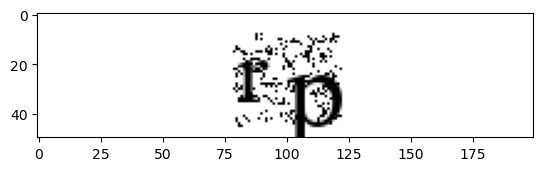

In [8]:
# 제대로 매칭되어 있는지 확인
sample = cv2.imread(x_train[0])
print(y_train[0])
plt.imshow(sample)

In [9]:
img_width = 200
img_height = 50

def encode_image(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_png(img, channels=1)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [img_height, img_width])
  img = tf.transpose(img, perm=[1,0,2])

  label = char_to_num(tf.strings.unicode_split(label, input_encoding = 'UTF-8'))

  return {'image':img, 'label':label}

In [10]:
# preview = encode_image(images[0], labels[0])
# print(labels[0])
# print(preview['label'])
# plt.imshow(preview['image'])

In [11]:
# 모델에 넣을 데이터셋 구성(배치 학습이 아니기 때문에 정해진 배치사이즈마다 일정한 양의 데이터 묶음을 넣어 학습 진행)

batch_size = 32
# tf가 제공하는 Dataset을 사용하는게 학습이 더 빨라서 일반적으로 사용하는 것 같습니다.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(
        encode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

print(train_dataset)
print(test_dataset)


<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>
<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>


In [26]:
# CTC손실함수 정의 : 정형화된 구현 방법이 존재하여 그대로 가져왔습니다.

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

def build_model():
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name='image', dtype='float32'
    )
    labels = layers.Input(name='label', shape=(None,), dtype='float32')

    # Convolution, Maxpooling을 각각 두번하여 차원을 축소함

    x = layers.Conv2D(
        32,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv1',
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name='pool1')(x)

    x = layers.Conv2D(
        64,
        (3, 3),
        activation='relu',
        kernel_initializer='he_normal',
        padding='same',
        name='Conv2',
    )(x)
    x = layers.MaxPooling2D((2, 2), name='pool2')(x)

    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)

    # RNN을 두 차례 사용
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # 출력층 구성
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation='softmax', name='dense2'
    )(x)

    # CTC 손실함수 적용
    output = CTCLayer(name='ctc_loss')(labels, x)

    # 모델 구성
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name='ocr_model_v1'
    )
    # 케라스에서 제공하는 최적화
    opt = keras.optimizers.Adam()

    model.compile(optimizer=opt)
    return model

In [27]:
#학습

model = build_model()

epochs = 250
stopping_patience = 50
#restore_best_weights : 조기종료 후 지금까지 최적값을 냈던 가중치를 다시 선택함
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=stopping_patience, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data = test_dataset,
    epochs = epochs,
    callbacks=[early_stopping],
)

Epoch 1/250
138/138 [==============================] - 13s 65ms/step - loss: 11.1430 - val_loss: 8.4501
Epoch 2/250
138/138 [==============================] - 8s 59ms/step - loss: 8.3737 - val_loss: 8.1563
Epoch 3/250
138/138 [==============================] - 8s 59ms/step - loss: 7.8512 - val_loss: 7.5602
Epoch 4/250
138/138 [==============================] - 8s 59ms/step - loss: 7.5065 - val_loss: 7.4658
Epoch 5/250
138/138 [==============================] - 8s 59ms/step - loss: 7.4596 - val_loss: 7.4587
Epoch 6/250
138/138 [==============================] - 8s 59ms/step - loss: 7.4469 - val_loss: 7.4539
Epoch 7/250
138/138 [==============================] - 8s 59ms/step - loss: 7.4386 - val_loss: 7.4534
Epoch 8/250
138/138 [==============================] - 8s 59ms/step - loss: 7.4356 - val_loss: 7.4547
Epoch 9/250
138/138 [==============================] - 8s 59ms/step - loss: 7.4285 - val_loss: 7.4513
Epoch 10/250
138/138 [==============================] - 8s 59ms/step - loss: 7.4

In [28]:
model.save('./2digitModel1.keras')
model.save_weights('./2digitModel1')

In [29]:
label_length = [len(label) for label in labels]
max_length = max(label_length)

In [30]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    output_text = []
    # encode된 글자를 복원하여 리스트에 저장
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)
    return output_text

def encode_image_only(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_png(img, channels=1)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = tf.image.resize(img, [img_height, img_width])
  img = tf.transpose(img, perm=[1,0,2])
    
  return img

In [31]:
prediction_model = keras.models.Model(
  model.get_layer(name='image').input, model.get_layer(name='dense2').output
)

In [32]:
def test_with_sample_image(model, path : str, label):
    image_tensor = encode_image_only(path)
    image_tensor = tf.expand_dims(image_tensor,0)
    pred = model.predict(image_tensor)
    pred_text = decode_batch_predictions(pred)
    print('prediction :',pred_text[0],' / ','Actual label :',label)

In [34]:
test_images, test_labels = images, labels = load_image_with_label('Test_Denoised','jpg')
print(test_labels)

['23', '23', '3q', '3q', '46', '46', '52', '52', '7d', '7d', '7n', '7n', '8z', '8z', '9b', '9b', 'a6', 'a6', 'am', 'am', 'bh', 'bh', 'cv', 'cv', 'e4', 'e4', 'mg', 'mg', 'mq', 'mq', 'n7', 'n7', 'nh', 'nh', 'p5', 'p5', 'pv', 'pv', 'qu', 'qu', 'vg', 'vg', 'x4', 'x4', 'xp', 'xp', 'xy', 'xy', 'yd', 'yd', 'z4', 'z4', 'zx', 'zx']


In [35]:
for i in range(len(test_labels)):
    test_with_sample_image(prediction_model,test_images[i],test_labels[i])

1/1 [==============================] - 1s 860ms/step
prediction : g3  /  Actual label : 23
1/1 [==============================] - 0s 54ms/step
prediction : 23  /  Actual label : 23
1/1 [==============================] - 0s 14ms/step
prediction : 3q  /  Actual label : 3q
1/1 [==============================] - 0s 16ms/step
prediction : 34  /  Actual label : 3q
1/1 [==============================] - 0s 14ms/step
prediction : 8o  /  Actual label : 46
1/1 [==============================] - 0s 14ms/step
prediction : 9o  /  Actual label : 46
1/1 [==============================] - 0s 13ms/step
prediction : 53  /  Actual label : 52
1/1 [==============================] - 0s 14ms/step
prediction : 8g  /  Actual label : 52
1/1 [==============================] - 0s 14ms/step
prediction : 74  /  Actual label : 7d
1/1 [==============================] - 0s 13ms/step
prediction : dq  /  Actual label : 7d
1/1 [==============================] - 0s 14ms/step
prediction : 4m  /  Actual label : 7n
1/1 [====